# Fraud detection

## Fraud_Data DataFrame:
* ## user_id: Unique user identifier.
* ## signup_time: Timestamp of user sign-up.
* ## purchase_time: Timestamp of purchase.
* ## purchase_value: Value of the purchase.
* ## device_id: Unique device identifier.
* ## source: Source of user arrival.
* ## browser: Web browser used by the user.
* ## sex: Gender of the user.
* ## age: Age of the user.
* ## ip_address: User's IP address.
* ## class: Transaction class (0 for non-fraudulent, 1 for fraudulent).
* ## IP_country: country related to this ip

In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
import datetime
import calendar
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Read the datasets
user_info = pd.read_csv("/kaggle/input/new-fraud/new_fraud.csv")    
user_info.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,IP_country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [2]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
 11  IP_country      151112 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 13.8+ MB


## Preprocessing User Info Data


In [3]:
# Print summary statistics 
print(user_info[["purchase_value", "age"]].describe())
print('*'*50)
# Print unique values and their frequencies 
for column in ["source", "browser", "sex"]:
    print(user_info[column].value_counts())
    print('*'*50)

# Check for duplicates in the "user_id" column in user_info DataFrame
print("The user_id column includes {} duplicates".format(user_info.duplicated(subset="user_id", keep=False).sum()))


       purchase_value            age
count   151112.000000  151112.000000
mean        36.935372      33.140704
std         18.322762       8.617733
min          9.000000      18.000000
25%         22.000000      27.000000
50%         35.000000      33.000000
75%         49.000000      39.000000
max        154.000000      76.000000
**************************************************
source
SEO       60615
Ads       59881
Direct    30616
Name: count, dtype: int64
**************************************************
browser
Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: count, dtype: int64
**************************************************
sex
M    88293
F    62819
Name: count, dtype: int64
**************************************************
The user_id column includes 0 duplicates


## Visualization of Fraud Proportion

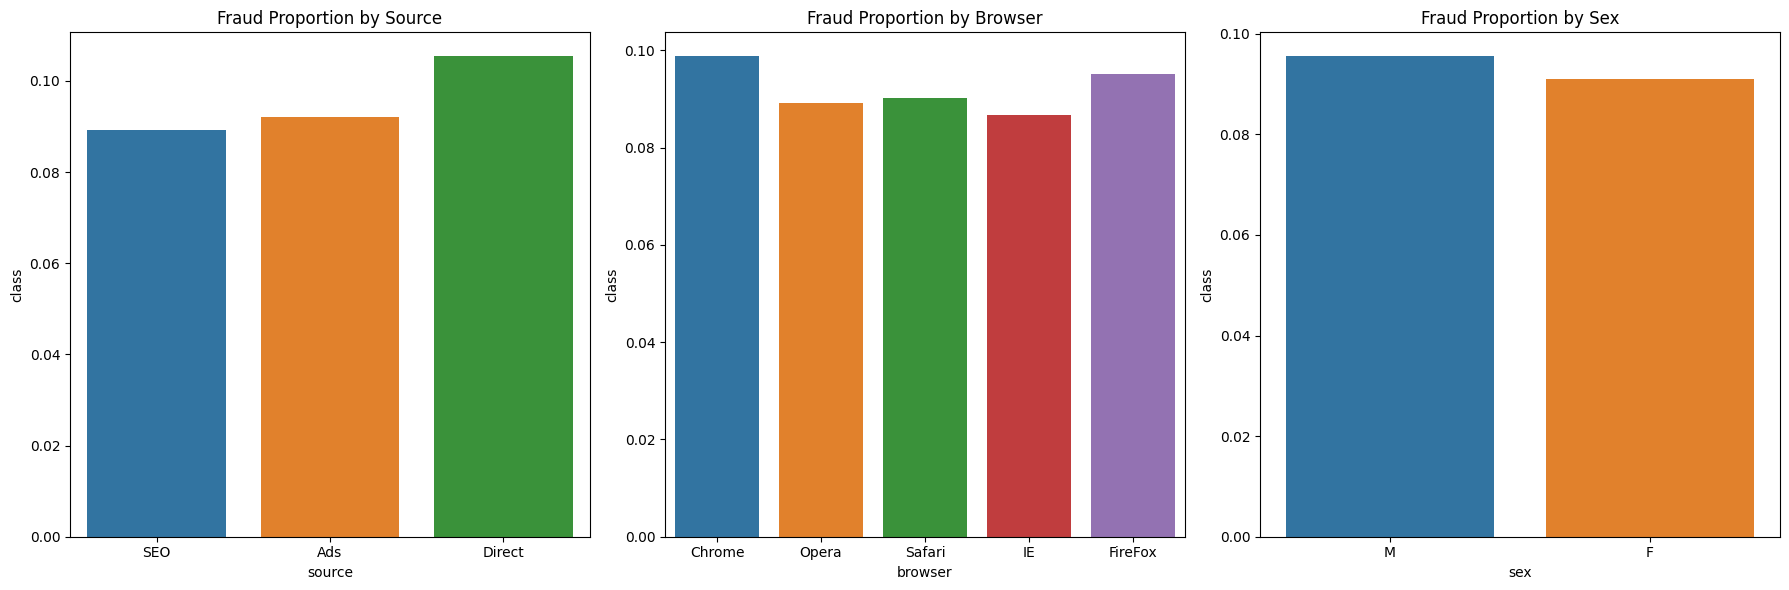

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(18, 6))

# Create subplots for bar plots
plt.subplot(1, 3, 1)
sns.barplot(x='source', y='class', data=user_info, ci=None)
plt.title('Fraud Proportion by Source')

plt.subplot(1, 3, 2)
sns.barplot(x='browser', y='class', data=user_info, ci=None)
plt.title('Fraud Proportion by Browser')

plt.subplot(1, 3, 3)
sns.barplot(x='sex', y='class', data=user_info, ci=None)
plt.title('Fraud Proportion by Sex')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


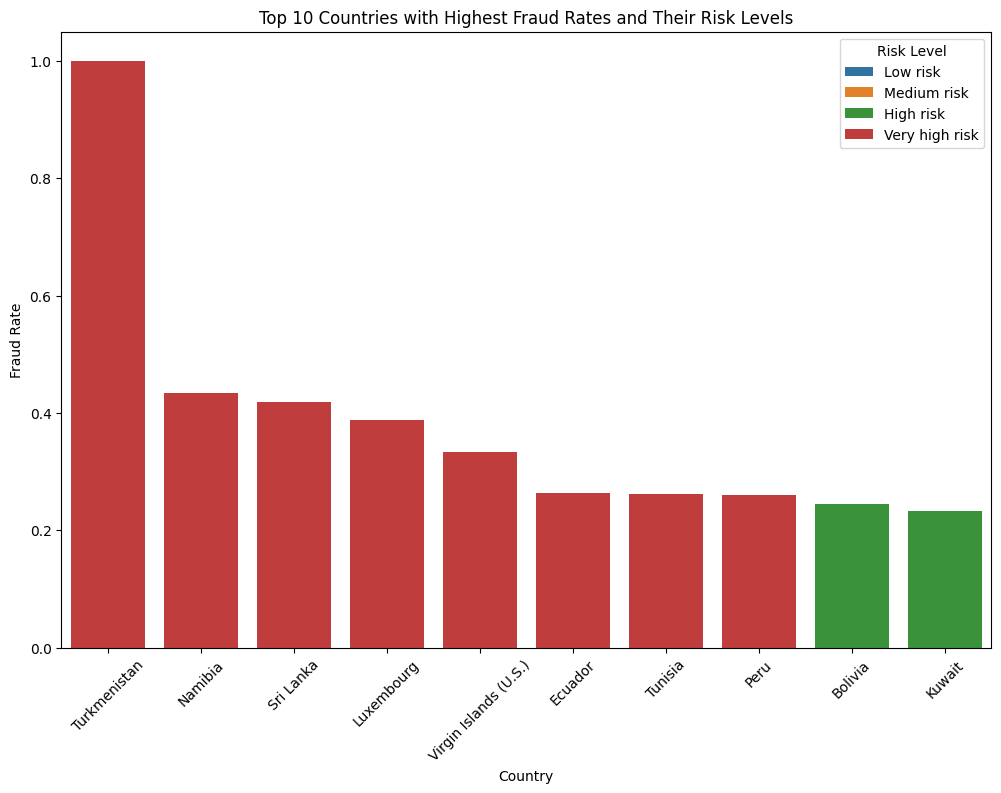

In [19]:
# Calculate the proportion of fraudulent transactions for each country
fraud_rate_by_country = user_info.groupby('IP_country')['class'].mean().sort_values(ascending=False)

# Categorize countries based on their fraud rates into risk levels
risk_levels = pd.cut(fraud_rate_by_country, bins=[-np.inf, 0.01, 0.05, 0.25, np.inf], labels=['Low risk', 'Medium risk', 'High risk', 'Very high risk'])

# Combine the results into a DataFrame
risk_country = pd.DataFrame({'fraud_rate': fraud_rate_by_country, 'risk_level': risk_levels})

top_10_countries = risk_country.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_countries.index, y='fraud_rate', data=top_10_countries, hue='risk_level', dodge=False)
plt.xticks(rotation=45)
plt.xlabel('Country')
plt.ylabel('Fraud Rate')
plt.title('Top 10 Countries with Highest Fraud Rates and Their Risk Levels')
plt.legend(title='Risk Level')
plt.show()


## Data Transformation

****Converted "purchase_time" and "signup_time" columns to datetime format using pd.to_datetime() function.****

In [4]:
user_info["purchase_time"] = pd.to_datetime(user_info["purchase_time"])
user_info["signup_time"] = pd.to_datetime(user_info["signup_time"])
user_info.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,IP_country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


## Feature Engineering

****Created a new feature month_purchase,weekday_purchase,hour_of_the_day to represent the month of purchase,day of the week of purchase, hour of the day using the calendar module.****

In [5]:
user_info["month_purchase"] = user_info.purchase_time.apply(
    lambda x: calendar.month_name[x.month])

# Column week
user_info["weekday_purchase"] = user_info.purchase_time.apply(
    lambda x: calendar.day_name[x.weekday()])


# Column hour_of_the_day
user_info["hour_of_the_day"] = user_info.purchase_time.apply(lambda x: x.hour)
user_info.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,IP_country,month_purchase,weekday_purchase,hour_of_the_day
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,April,Saturday,2
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,June,Monday,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,January,Thursday,18
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown,May,Monday,13
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,September,Wednesday,18


### Hour of the Day Categorization
Time Period Categories:
* Late Night: Hours before 4 AM.
* Early Morning: Hours between 4 AM to 8 AM.
* Morning: Hours between 8 AM to 12 PM.
* Early Afternoon (Early Arvo): Hours between 12 PM to 4 PM.
* Afternoon (Arvo): Hours between 4 PM to 8 PM.
* Evening: Hours after 8 PM.

In [6]:
# Hour of the day categorisation
user_info["period_of_the_day"] = user_info.hour_of_the_day.apply(lambda x:
                                                                 "late night" if x < 4 else
                                                                 "early morning" if x < 8 else
                                                                 "morning" if x < 12 else
                                                                 "early arvo" if x < 16 else
                                                                 "arvo" if x < 20 else
                                                                 "evening"
                                                                 )

### Age Categories:
* < 40: Users below the age of 40.
* 40 - 49: Users aged between 40 and 49 (inclusive).
* 50 - 59: Users aged between 50 and 59 (inclusive).
* 60 - 69: Users aged between 60 and 69 (inclusive).
* >70: Users aged 70 and above.

In [7]:
# age categorisation
user_info["age_category"] = user_info.age.apply(lambda x:
                                                "< 40" if x < 40 else
                                                "40 - 49" if x < 50 else
                                                "50 -59" if x < 60 else
                                                "60 - 69" if x < 70 else
                                                " > 70")

### Seconds Since Signup

****Created a new feature "seconds_since_signup" to calculate the time duration in seconds between the purchase time and signup time for each user.****

In [8]:
user_info["seconds_since_signup"] = (
    user_info.purchase_time - user_info.signup_time).apply(lambda x: x.total_seconds())

### Quick Purchase

****Created a new binary feature "quick_purchase" to identify purchases made within a short time frame after signup.****

In [ ]:
user_info["quick_purchase"] = user_info.seconds_since_signup.apply(
    lambda x: 1 if x < 30 else 0)

### Data Cleaning
* Remove a list of columns (UNNECESSARY)
* Removed rows with missing values 

In [10]:
# Define the list of columns to remove
columns_to_remove = ["user_id", "signup_time", "purchase_time", "device_id",
                     "ip_address", "hour_of_the_day", "seconds_since_signup", "age"]

# Drop the specified columns from the DataFrame
user_info.drop(columns_to_remove, axis=1, inplace=True)

# Drop rows with missing values from the user_info dataset
user_info.dropna(inplace=True)

In [11]:
user_info.head()

,purchase_value,source,browser,sex,class,IP_country,month_purchase,weekday_purchase,period_of_the_day,age_category
0,34,SEO,Chrome,M,0,Japan,April,Saturday,late night,< 40
1,16,Ads,Chrome,F,0,United States,June,Monday,late night,50 -59
2,15,SEO,Opera,M,1,United States,January,Thursday,arvo,50 -59
3,44,SEO,Safari,M,0,Unknown,May,Monday,early arvo,40 - 49
4,39,Ads,Safari,M,0,United States,September,Wednesday,arvo,40 - 49


## Data Preprocessing


### One-Hot Encoding
****Performed one-hot encoding on the categorical features of the "user_info" dataset, excluding the target variable "class".****

In [12]:
# Data preprocessing
features = pd.get_dummies(user_info.drop("class", axis=1), drop_first=True)
target = user_info["class"]

# Save column names for future use
train_columns = features.columns.tolist()
train_columns

['purchase_value',
 'source_Direct',
 'source_SEO',
 'browser_FireFox',
 'browser_IE',
 'browser_Opera',
 'browser_Safari',
 'sex_M',
 'IP_country_Albania',
 'IP_country_Algeria',
 'IP_country_Angola',
 'IP_country_Antigua and Barbuda',
 'IP_country_Argentina',
 'IP_country_Armenia',
 'IP_country_Australia',
 'IP_country_Austria',
 'IP_country_Azerbaijan',
 'IP_country_Bahamas',
 'IP_country_Bahrain',
 'IP_country_Bangladesh',
 'IP_country_Barbados',
 'IP_country_Belarus',
 'IP_country_Belgium',
 'IP_country_Belize',
 'IP_country_Benin',
 'IP_country_Bermuda',
 'IP_country_Bhutan',
 'IP_country_Bolivia',
 'IP_country_Bonaire; Sint Eustatius; Saba',
 'IP_country_Bosnia and Herzegowina',
 'IP_country_Botswana',
 'IP_country_Brazil',
 'IP_country_British Indian Ocean Territory',
 'IP_country_Brunei Darussalam',
 'IP_country_Bulgaria',
 'IP_country_Burkina Faso',
 'IP_country_Burundi',
 'IP_country_Cambodia',
 'IP_country_Cameroon',
 'IP_country_Canada',
 'IP_country_Cape Verde',
 'IP_coun

### Saving Column Names

* Saved the list of column names of the preprocessed features into a file named "train_columns.pkl".
* The column names can be loaded from this file later for use in other scripts or notebooks without needing to recompute them.

In [14]:
import pickle
# Save train_columns
with open("train_columns.pkl", "wb") as f:
    pickle.dump(train_columns, f)

In [20]:
user_info["class"].value_counts()

class
0    136961
1     14151
Name: count, dtype: int64

## Model Training and Evaluation
### Logistic regression

## Splitting the Data

**The dataset is split into training and test sets using train_test_split()**

1. X_train, X_test: Feature sets for training and testing.
1. y_train, y_test: Target variables for training and testing.
1. random_state=42 ensures reproducibility of the split.
1. stratify=target ensures that the class distribution is preserved in both training and test sets.
1. test_size=0.25 specifies that 25% of the data will be used for testing.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    random_state=42,
                                                    stratify=target,
                                                    test_size=0.25)

## Model Fitting

* A logistic regression model is instantiated and fitted to the training data
* max_iter=1000 sets the maximum number of iterations for optimization.


In [29]:
# Fitting a logistic regression model
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

* Train score represents the accuracy of the model on the training data.
* Test score represents the accuracy of the model on the test data.

In [30]:
# Printing scores
train_score = logistic_regression.score(X_train, y_train)
test_score = logistic_regression.score(X_test, y_test)
print("Train Score:", round(train_score * 100, 2), "%")
print("Test Score:", round(test_score * 100, 2), "%")

Train Score: 94.23 %
Test Score: 94.04 %


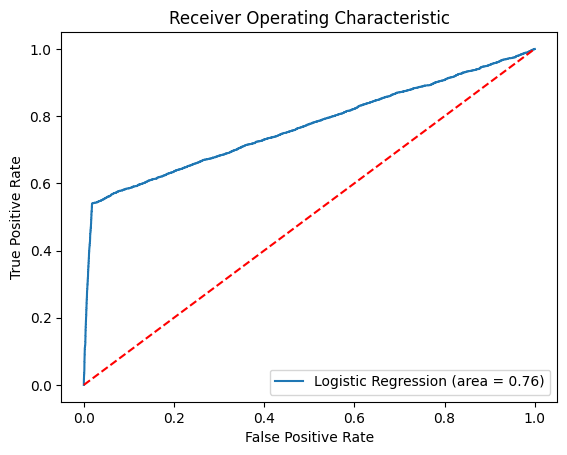

In [31]:
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate ROC AUC score
logit_roc_auc = roc_auc_score(y_test, logistic_regression.predict(X_test))

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, logistic_regression.predict_proba(X_test)[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


In [32]:
# Save the model to a file using pickle
with open('ecommerce_log_reg.pkl', 'wb') as f:
    pickle.dump(logistic_regression, f)

In [33]:
# Load the pre-trained logistic regression model
with open("ecommerce_log_reg.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# use the loaded model to make predictions
predicted_classes = loaded_model.predict(X_test)

In [34]:
from sklearn.metrics import accuracy_score

# Calculate accuracy score
accuracy = accuracy_score(y_test, predicted_classes)
print("Accuracy:", accuracy) 

Accuracy: 0.9403621155169676


 ## confusion matrix:

* True Positives (TP): The number of instances that are positive and were correctly classified as positive.
* True Negatives (TN): The number of instances that are negative and were correctly classified as negative.
* False Positives (FP): Also known as Type I error, the number of instances that are negative but were incorrectly classified as positive.
* False Negatives (FN): Also known as Type II error, the number of instances that are positive but were incorrectly classified as negative.

|                         | Predicted Positive | Predicted Negative |
|-------------------------|--------------------|--------------------|
| **Actual Positive**     |        TP          |        FN          |
| **Actual Negative**     |        FP          |        TN          |



## Precision:
- Precision measures the accuracy of positive predictions made by the classifier. It is calculated as the ratio of true positives to the sum of true positives and false positives.
- Precision indicates the proportion of correctly predicted positive instances among all instances predicted as positive.
- High precision indicates a low false positive rate, meaning that the classifier is conservative when labeling instances as positive.

**Precision = TP / (TP + FP).**

## Recall (Sensitivity):
- Recall measures the ability of the classifier to correctly identify positive instances from all actual positive instances. It is calculated as the ratio of true positives to the sum of true positives and false negatives.
- Recall indicates the proportion of correctly predicted positive instances among all actual positive instances.
- High recall indicates a low false negative rate, meaning that the classifier is able to capture most of the positive instances.

**Recall = TP / (TP + FN)**
 
## F1-Score:
- F1-Score is the harmonic mean of precision and recall. It provides a balance between precision and recall, giving equal weight to both metrics.
- F1-Score reaches its best value at 1 and worst at 0. It is a useful metric when the class distribution is imbalanced.
- F1-Score penalizes classifiers with imbalanced precision and recall, promoting a balance between the two.

**F1-Score = 2 * (Precision * Recall) / (Precision + Recall).**
## Support:
- Support is the number of actual occurrences of each class in the specified dataset.
- It represents the number of instances in the dataset that belong to each class.
- Support is crucial for interpreting the significance of precision, recall, and F1-Score. Classes with higher support have more influence on the overall performance metrics.


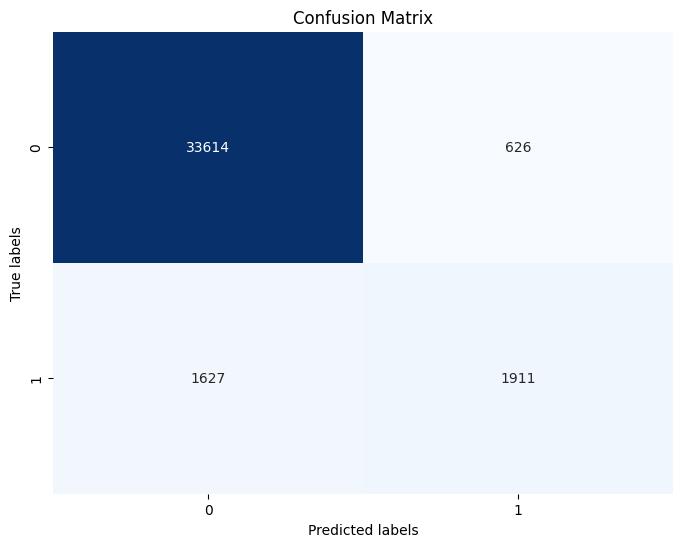

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     34240
           1       0.75      0.54      0.63      3538

    accuracy                           0.94     37778
   macro avg       0.85      0.76      0.80     37778
weighted avg       0.94      0.94      0.94     37778



In [36]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Generate classification report
class_report = classification_report(y_test, predicted_classes)
print("Classification Report:")
print(class_report)

# Malicious URL Detection

## DataFrame Description:

*This DataFrame contains website URLs along with their corresponding types.*

*  url: The URL of the website.
*  type: The type of website, categorized into various types such as phishing, benign, defacement, etc.

In [39]:
!pip install python-whois
!pip install tld


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 13.4 MB/s eta 0:00:00


In [129]:
# Importing dependencies
import pickle
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score, auc, roc_curve
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import math
from urllib.parse import urlparse
from collections import Counter
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
# from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
import os
import socket
import whois
from datetime import datetime
import time
from bs4 import BeautifulSoup
import urllib
import bs4
import os
import re
from tld import get_tld
from lightgbm import LGBMClassifier

In [41]:
df=pd.read_csv('/kaggle/input/malicious-urls-dataset/malicious_phish.csv')

print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [42]:
df["type"].value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

## Feature Engineering


### having_ip_address(url)
* to check if a URL contains an IP address
* The re library is imported to use regular expressions for pattern matching.
* It uses a regular expression pattern to search for IPv4 and IPv6 addresses in the URL.

In [44]:
import re

def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))
print(df.head())

                                                 url        type  use_of_ip
0                                   br-icloud.com.br    phishing          0
1                mp3raid.com/music/krizz_kaliko.html      benign          0
2                    bopsecrets.org/rexroth/cr/1.htm      benign          0
3  http://www.garage-pirenne.be/index.php?option=...  defacement          0
4  http://adventure-nicaragua.net/index.php?optio...  defacement          0


In [45]:
df.use_of_ip.value_counts()

use_of_ip
0    643898
1      7293
Name: count, dtype: int64

In [46]:
example_with_ip = df[df['use_of_ip'] == 1].iloc[0]

# Print the example
print("Example with IP Address:")
print(example_with_ip)

Example with IP Address:
url          http://219.232.244.89/intl/update/error_login.htm
type                                                  phishing
use_of_ip                                                    1
Name: 10408, dtype: object


### abnormal_url(url)

**checks if the URL appears to be abnormal based on the comparison between the hostname extracted from the URL and the entire URL string.**

* It extracts the hostname from the URL using urlparse(url).hostname.
* It converts the hostname to a string for comparison.
* it searches for the hostname within the entire URL string using a regular expression.
* If the hostname is found within the URL, it returns 1 (indicating an abnormal URL); otherwise, it returns 0.

In [47]:
from urllib.parse import urlparse
import re

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        return 1
    else:
        return 0

df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))
df.head()

,url,type,use_of_ip,abnormal_url
0,br-icloud.com.br,phishing,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1


In [61]:
ex_url=df['url'].iloc[4]
ex_url

'http://adventure-nicaragua.net/index.php?option=com_mailto&tmpl=component&link=aHR0cDovL2FkdmVudHVyZS1uaWNhcmFndWEubmV0L2luZGV4LnBocD9vcHRpb249Y29tX2NvbnRlbnQmdmlldz1hcnRpY2xlJmlkPTQ3OmFib3V0JmNhdGlkPTM2OmRlbW8tYXJ0aWNsZXMmSXRlbWlkPTU0'

In [62]:
urlparse(ex_url).hostname

'adventure-nicaragua.net'

In [49]:
example_abnormal_url = df[df['abnormal_url'] == 1].iloc[1]

# Print the example
print("Example with Abnormal URL:")
print(example_abnormal_url)

Example with Abnormal URL:
url             http://adventure-nicaragua.net/index.php?optio...
type                                                   defacement
use_of_ip                                                       0
abnormal_url                                                    1
Name: 4, dtype: object


In [50]:
example_normal_url = df[df['abnormal_url'] == 0].iloc[0]

# Print the example
print("Example with Abnormal URL:")
print(example_normal_url)

Example with Abnormal URL:
url             br-icloud.com.br
type                    phishing
use_of_ip                      0
abnormal_url                   0
Name: 0, dtype: object


In [63]:
df.abnormal_url.value_counts()

abnormal_url
0    463185
1    188006
Name: count, dtype: int64

In [64]:
!pip install googlesearch-python

* Count of Periods ('.') :calculates the number of occurrences of the period ('.') character in each URL
* Count of 'www' in URL: calculates the number of occurrences of the substring 'www' in each URL
* Count of '@' in URL:  calculates the number of occurrences of the '@' character in each URL

In [ ]:
df['count.'] = df['url'].apply(lambda i: i.count('.'))


In [66]:
import re
from urllib.parse import urlparse

# Count occurrences of 'www'
df['count-www'] = df['url'].apply(lambda i: i.count('www'))
print(df['count-www'].value_counts())
df.head()

count-www
0    525525
1    124178
2      1422
3        58
4         7
5         1
Name: count, dtype: int64


,url,type,use_of_ip,abnormal_url,count.,count-www
0,br-icloud.com.br,phishing,0,0,2,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,2,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,2,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,3,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,2,0


In [67]:
# Count occurrences of '@'
df['count@'] = df['url'].apply(lambda i: i.count('@'))
print(df['count@'].value_counts())
df.tail()

count@
0     649845
1       1290
2         40
3          9
4          3
10         3
6          1
Name: count, dtype: int64


,url,type,use_of_ip,abnormal_url,count.,count-www,count@
651186,xbox360.ign.com/objects/850/850402.html,phishing,0,0,3,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,0,0,2,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,0,0,2,1,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,0,0,2,0,0
651190,www.angelfire.com/goth/devilmaycrytonite/,phishing,0,0,2,1,0


## no_of_dir(url)

*  counts the number of directories in the path component of a URL
*  extracts the path component from the URL,then counts the number of occurrences of the '/' character in the path, which corresponds to the number of directories.

In [70]:
# Count number of directories in the path component
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
print(df["url"][3])
print(no_of_dir(df["url"][3]))
print(df["url"][5])
print(no_of_dir(df["url"][5]))

http://www.garage-pirenne.be/index.php?option=com_content&view=article&id=70&vsig70_0=15
1
http://buzzfil.net/m/show-art/ils-etaient-loin-de-s-imaginer-que-le-hibou-allait-faire-ceci-quand-ils-filmaient-2.html
3


In [ ]:
df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))


In [72]:
df.head()

,url,type,use_of_ip,abnormal_url,count.,count-www,count@,count_dir
0,br-icloud.com.br,phishing,0,0,2,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,2,0,0,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,2,0,0,3
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,3,1,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,2,0,0,1


### no_of_embed(url)
**count of occurrences of '//' in its path component.**

In [75]:
# Count occurrences of '//'
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')



In [74]:
df['count_embed_domain'] = df['url'].apply(lambda i: no_of_embed(i))
df.head()

,url,type,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domain
0,br-icloud.com.br,phishing,0,0,2,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,2,0,0,2,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,2,0,0,3,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,3,1,0,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,2,0,0,1,0


In [77]:
example_url = df[df['count_embed_domain'] == 1].iloc[0]

# Print the example
print("Example with count_embed_domain URL:")
print(example_url["url"])

Example with count_embed_domain URL:
http://steamcommunity.com/stats/TF2/achievements/%22http://store.steampowered.com/curators/%22


### shortening_service(url): 
****check if a URL is shortened using a URL shortening service like tinyurl or bit.ly****

In [78]:
# Check for URL shortening service
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

df.head()

,url,type,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domain,short_url
0,br-icloud.com.br,phishing,0,0,2,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,2,0,0,2,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,2,0,0,3,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,3,1,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,2,0,0,1,0,0


In [96]:
example_short_url = df[df['short_url'] == 1].iloc[0]

# Print the example
print("Example with short_url URL:")
print(example_short_url["url"])

Example with short_url URL:
yourbittorrent.com/?q=anthony-hamilton-soulife


In [97]:
# Count occurrences of 'https'
df['count-https'] = df['url'].apply(lambda i: i.count('https'))

# Count occurrences of 'http'
df['count-http'] = df['url'].apply(lambda i: i.count('http'))

# Count occurrences of '%'
df['count%'] = df['url'].apply(lambda i: i.count('%'))

# Count occurrences of '?'
df['count?'] = df['url'].apply(lambda i: i.count('?'))

# Count occurrences of '-'
df['count-'] = df['url'].apply(lambda i: i.count('-'))

# Count occurrences of '='
df['count='] = df['url'].apply(lambda i: i.count('='))

# Length of URL
df['url_length'] = df['url'].apply(lambda i: len(str(i)))

# Hostname Length
df['hostname_length'] = df['url'].apply(lambda i: len(urlparse(i).netloc))

In [98]:
df.head()

,url,type,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domain,short_url,count-https,count-http,count%,count?,count-,count=,url_length,hostname_length
0,br-icloud.com.br,phishing,0,0,2,0,0,0,0,0,0,0,0,0,1,0,16,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,2,0,0,2,0,0,0,0,0,0,0,0,35,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,2,0,0,3,0,0,0,0,0,0,0,0,31,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,3,1,0,1,0,0,0,1,0,1,1,4,88,21
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,2,0,0,1,0,0,0,1,0,1,1,3,235,23


In [99]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0

df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))

df.tail()

,url,type,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domain,short_url,count-https,count-http,count%,count?,count-,count=,url_length,hostname_length,sus_url
651186,xbox360.ign.com/objects/850/850402.html,phishing,0,0,3,0,0,3,0,0,0,0,0,0,0,0,39,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,0,0,2,0,0,4,0,1,0,0,0,0,2,0,44,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,0,0,2,1,0,4,0,1,0,0,0,0,0,0,42,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,0,0,2,0,0,2,0,0,0,0,0,0,0,0,45,0,0
651190,www.angelfire.com/goth/devilmaycrytonite/,phishing,0,0,2,1,0,3,0,0,0,0,0,0,0,0,41,0,0


In [100]:
example_sus_url = df[df['sus_url'] == 1].iloc[0]

# Print the example
print("Example with short_url URL:")
print(example_sus_url["url"])

Example with short_url URL:
signin.eby.de.zukruygxctzmmqi.civpro.co.za


In [101]:
!pip install tld

### fd_length(url)
calculate the length of the first directory in a URL path.

In [102]:
# Importing dependencies
from urllib.parse import urlparse
from tld import get_tld

# First Directory Length
def fd_length(url):
    urlpath = urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

print(df.url[8])
print(fd_length(df.url[8]))
print(get_tld(df.url[8], fail_silently=True))

http://www.pashminaonline.com/pure-pashminas
14
com


Explanation:

The URL **http://www.pashminaonline.com/pure-pashminas** has the following structure: protocol://domain/path. The path component of the URL is /pure-pashminas.
After splitting the path by /, the first part is pure-pashminas. The length of the first directory is 14 characters (pure-pashminas).
The top-level domain (TLD) of the URL is com.

In [103]:
# Adding 'fd_length' column
df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

# Get Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i, fail_silently=True))

In [104]:
# Function to calculate length of TLD
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

# Adding 'tld_length' column
df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))


In [105]:
df.head()

,url,type,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domain,short_url,...,count%,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld,tld_length
0,br-icloud.com.br,phishing,0,0,2,0,0,0,0,0,...,0,0,1,0,16,0,0,0,None,-1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,2,0,0,2,0,0,...,0,0,0,0,35,0,0,5,None,-1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,2,0,0,3,0,0,...,0,0,0,0,31,0,0,7,None,-1
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,3,1,0,1,0,0,...,0,1,1,4,88,21,0,9,be,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,2,0,0,1,0,0,...,0,1,1,3,235,23,0,9,net,3


In [106]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

# Adding a new column 'count-digits' to the DataFrame
df['count-digits'] = df['url'].apply(lambda i: digit_count(i))

In [113]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
df['count-letters']= df['url'].apply(lambda i: letter_count(i))

In [118]:
df.head()

,url,type,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domain,short_url,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,br-icloud.com.br,phishing,0,0,2,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,2,0,0,2,0,0,...,0,0,0,35,0,0,5,-1,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,2,0,0,3,0,0,...,0,0,0,31,0,0,7,-1,1,25
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,3,1,0,1,0,0,...,1,1,4,88,21,0,9,2,7,63
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,2,0,0,1,0,0,...,1,1,3,235,23,0,9,3,22,199


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   url                 651191 non-null  object
 1   type                651191 non-null  object
 2   use_of_ip           651191 non-null  int64 
 3   abnormal_url        651191 non-null  int64 
 4   count.              651191 non-null  int64 
 5   count-www           651191 non-null  int64 
 6   count@              651191 non-null  int64 
 7   count_dir           651191 non-null  int64 
 8   count_embed_domain  651191 non-null  int64 
 9   short_url           651191 non-null  int64 
 10  count-https         651191 non-null  int64 
 11  count-http          651191 non-null  int64 
 12  count%              651191 non-null  int64 
 13  count?              651191 non-null  int64 
 14  count-              651191 non-null  int64 
 15  count=              651191 non-null  int64 
 16  ur

## Model training

In [125]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
print(df["type"].value_counts())
print("***"*20)
print("after encoding:")
print(df["type_code"].value_counts())

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64
************************************************************
after encoding:
type_code
0    428103
1     96457
3     94111
2     32520
Name: count, dtype: int64


In [126]:
# Predictor Variables
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
        'count_dir', 'count_embed_domain', 'short_url', 'count-https',
        'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
        'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
        'count-letters']]

# Target Variable
y = df['type_code']


In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

In [130]:
lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5, 
          silent = True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)


y_pred = LGB_C.predict(X_test)
print(classification_report(y_test,y_pred))

score = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 520952, number of used features: 21
[LightGBM] [Info] Start training from score -0.419439
[LightGBM] [Info] Start training from score -1.909712
[LightGBM] [Info] Start training from score -2.996946
[LightGBM] [Info] Start training from score -1.934324
[LightGBM] [Warning] Unknown parameter: silent
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     85621
           1       0.96      0.99      0.98     19292
           2       0.97      0.90      0.93      6504
           3       0.90      0.83      0.86     18822

    accuracy                           0.96    130239
   macro avg       0.95    

In [132]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


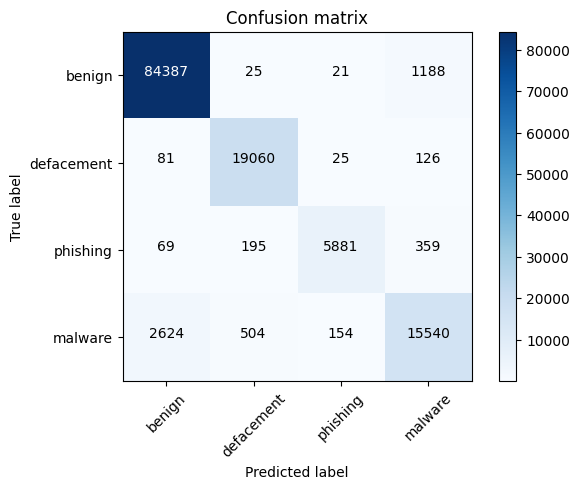

In [133]:
cm = metrics.confusion_matrix(y_test, y_pred, labels=[0,1,2,3])
plot_confusion_matrix(cm,classes=['benign', 'defacement','phishing','malware'])

In [134]:
lgb_feature = lgb.feature_importances_
lgb_feature

array([  28,   59, 1002,  504,   70, 1145,   46,  147,  246,  153,  253,
        220,  577,  424, 1057, 1499,  248, 1731,  639, 1178,  774],
      dtype=int32)

In [135]:
lgb_features = lgb_feature.tolist()
lgb_features

[28,
 59,
 1002,
 504,
 70,
 1145,
 46,
 147,
 246,
 153,
 253,
 220,
 577,
 424,
 1057,
 1499,
 248,
 1731,
 639,
 1178,
 774]

In [136]:
import pickle

# Save the model to a file
with open('mul_urls_lgb_model.pkl', 'wb') as f:
    pickle.dump(LGB_C, f)


In [137]:
from sklearn.metrics import accuracy_score
with open('mul_urls_lgb_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

y_pred = loaded_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)

[LightGBM] [Warning] Unknown parameter: silent
Accuracy Score: 0.9587604327428804


In [138]:
model = xgb.XGBClassifier(n_estimators= 100)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))


score = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     85621
           1       0.97      0.99      0.98     19292
           2       0.98      0.91      0.94      6504
           3       0.91      0.83      0.87     18822

    accuracy                           0.96    130239
   macro avg       0.96      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.962


Confusion matrix, without normalization


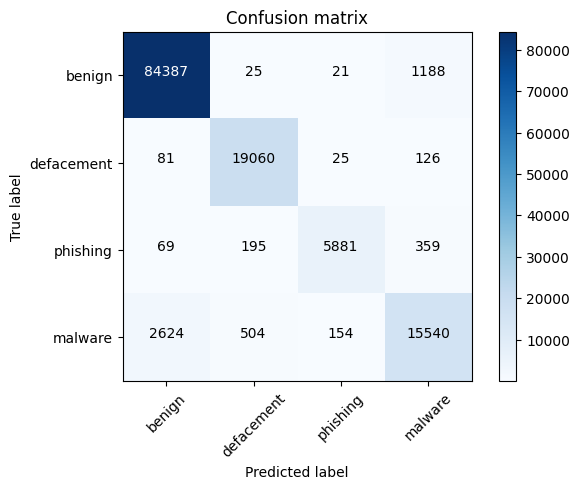

In [139]:
CM=confusion_matrix(y_test,y_pred,labels=[0,1,2,3])

plot_confusion_matrix(cm,classes=['benign', 'defacement','phishing','malware'])

In [140]:
import pickle

# Save the model to a file
with open('mul_url_xgb.pkl', 'wb') as f:
    pickle.dump(model, f)

In [141]:
xgb_feature = model.feature_importances_
xgb_features = xgb_feature.tolist()

In [142]:
from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier(n_estimators=100,max_features='sqrt')
gbdt.fit(X_train,y_train)
y_pred = gbdt.predict(X_test)
print(classification_report(y_test,y_pred))

score = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     85621
           1       0.90      0.97      0.93     19292
           2       0.93      0.78      0.85      6504
           3       0.88      0.74      0.81     18822

    accuracy                           0.94    130239
   macro avg       0.92      0.87      0.89    130239
weighted avg       0.94      0.94      0.93    130239

accuracy:   0.937


Confusion matrix, without normalization


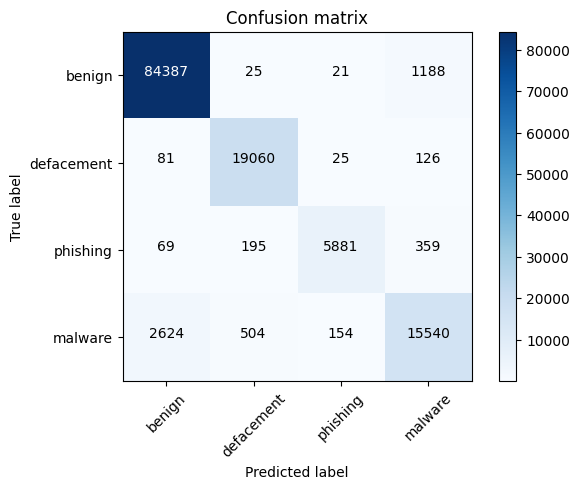

In [143]:
CM=confusion_matrix(y_test,y_pred,labels=[0,1,2,3])

plot_confusion_matrix(cm,classes=['benign', 'defacement','phishing','malware'])

In [144]:
import pickle

# Save the model to a file
with open('mul_url_gbdt.pkl', 'wb') as f:
    pickle.dump(gbdt, f)

In [145]:
gbdt_feature = gbdt.feature_importances_
gbdt_features = gbdt_feature.tolist()

In [146]:
print(gbdt_features)
print(xgb_features)
print(lgb_features)


[0.018692632948612502, 0.08697333335121143, 0.06216370398409494, 0.0902130641803221, 0.0006429096073671241, 0.12321233250590229, 0.00013301739541125368, 0.00017084812035873684, 0.02262597345375107, 0.14807645253086435, 0.011326627369482378, 0.010618122847180502, 0.01782652359801122, 0.021889708538386846, 0.03894596622455799, 0.1679000063937449, 0.006022312274096519, 0.03396226741274517, 0.0765161067678874, 0.028621400804370478, 0.03346668969164084]
[0.20144148170948029, 0.009954011999070644, 0.012986901216208935, 0.11788150668144226, 0.011392002925276756, 0.05773505941033363, 0.004404240753501654, 0.004324162844568491, 0.04681212827563286, 0.12727655470371246, 0.02110540308058262, 0.009652560576796532, 0.020793752744793892, 0.014066829346120358, 0.0252049770206213, 0.08040688931941986, 0.026125505566596985, 0.016310779377818108, 0.17117932438850403, 0.010690119117498398, 0.010255822911858559]
[28, 59, 1002, 504, 70, 1145, 46, 147, 246, 153, 253, 220, 577, 424, 1057, 1499, 248, 1731, 63

In [147]:
cols = X_train.columns
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
    
    'Gradient Boost feature importances': gbdt_features,
    'XG Boost feature importances': xgb_features,
    'LGBM feature importances': lgb_features
                                   
    })
feature_dataframe

,features,Gradient Boost feature importances,XG Boost feature importances,LGBM feature importances
0,use_of_ip,0.018693,0.201441,28
1,abnormal_url,0.086973,0.009954,59
2,count.,0.062164,0.012987,1002
3,count-www,0.090213,0.117882,504
4,count@,0.000643,0.011392,70
5,count_dir,0.123212,0.057735,1145
6,count_embed_domain,0.000133,0.004404,46
7,short_url,0.000171,0.004324,147
8,count-https,0.022626,0.046812,246
9,count-http,0.148076,0.127277,153


In [148]:
# Select only the numeric columns for calculating the mean
numeric_cols = feature_dataframe.columns[1:]  # Exclude the 'features' column
feature_dataframe['mean'] = feature_dataframe[numeric_cols].mean(axis=1)


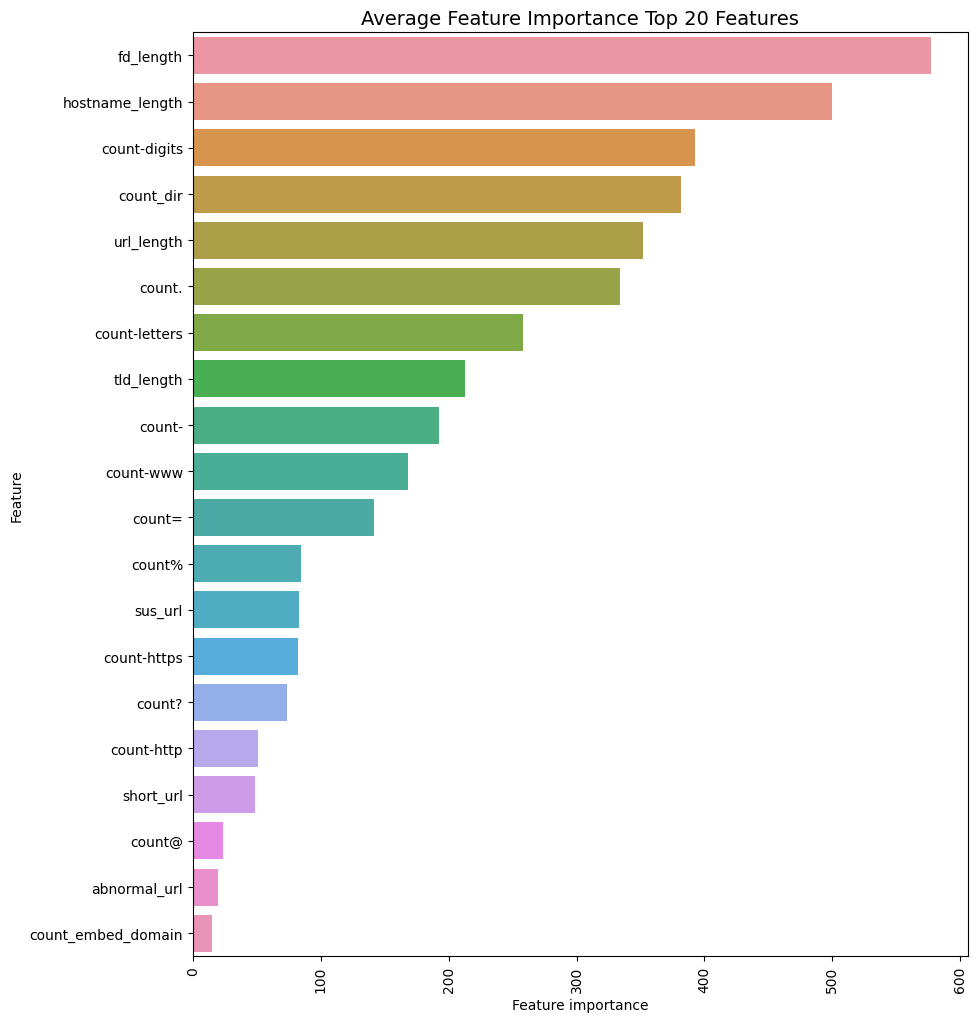

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
def plot_feature_importance():
    tmp = pd.DataFrame({'Feature': X_test.columns, 'Feature importance': feature_dataframe['mean'].values})
    tmp = tmp.sort_values(by='Feature importance',ascending=False).head(20)
    plt.figure(figsize = (10,12))
    plt.title('Average Feature Importance Top 20 Features',fontsize=14)
    s = sns.barplot(y='Feature',x='Feature importance',data=tmp, orient='h')
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()
plot_feature_importance()

#  Bots detection

## DataFrame Description:

**This DataFrame contains data related to  accounts and their attributes, along with a column indicating whether each account is detected as a bot.**

* has_default_profile: Indicates whether the user has a default profile.
* has_default_profile_img: Indicates whether the user has a default profile image.
* prod_fav_count: The number of products favorited by the user.
* followers_count: The number of followers the user has.
* friends_count: The number of friends (accounts the user follows) the user has.
* is_geo_enabled: Indicates whether the user has geo-location enabled.
* user_id: Unique identifier for each user.
* user_lang: Language preference of the user.
* user_location: Location information provided by the user.
* username: User's username.
* purchase_count: The number of purchases made by the user.
* membership / subscription: Indicates whether the user has a membership or subscription.
* avg_purchases_per_day: Average number of purchases made by the user per day.
* account_age: Age of the user's account (in days).
* account_type: Type or category of the user's account.

In [189]:
# Basics
import pandas as pd
import numpy as np
import pickle

# Visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [190]:
raw_df = pd.read_csv("/kaggle/input/bots-ecommerce/ecommerce_human_bot.csv")
raw_df.head()

,created_at,has_default_profile,has_default_profile_img,prod_fav_count,followers_count,friends_count,is_geo_enabled,user_id,user_lang,user_location,username,purchase_count,membership / subscription,avg_purchases_per_day,account_age,account_type
0,2016-10-15 21:32:11,False,False,4,1589,4,False,787405734442958848,en,unknown,best_in_dumbest,11041,False,7.870,1403,bot
1,2016-11-09 05:01:30,False,False,536,860,880,False,796216118331310080,en,Estados Unidos,CJRubinPhoto,252,False,0.183,1379,human
2,2017-06-17 05:34:27,False,False,3307,172,594,True,875949740503859204,en,"Los Angeles, CA",SVGEGENT,1001,False,0.864,1159,human
3,2016-07-21 13:32:25,True,False,8433,517,633,True,756119643622735875,en,"Birmingham, AL",TinkerVHELPK5,1324,False,0.889,1489,human
4,2012-01-15 16:32:35,False,False,88,753678,116,True,464781334,en,"England, United Kingdom",JoleonLescott,4202,True,1.339,3138,human


In [191]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37435 entries, 0 to 37434
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   created_at                 37435 non-null  object 
 1   has_default_profile        37435 non-null  bool   
 2   has_default_profile_img    37435 non-null  bool   
 3   prod_fav_count             37435 non-null  int64  
 4   followers_count            37435 non-null  int64  
 5   friends_count              37435 non-null  int64  
 6   is_geo_enabled             37435 non-null  bool   
 7   user_id                    37435 non-null  int64  
 8   user_lang                  37435 non-null  object 
 9   user_location              37434 non-null  object 
 10  username                   37435 non-null  object 
 11  purchase_count             37435 non-null  int64  
 12  membership / subscription  37435 non-null  bool   
 13  avg_purchases_per_day      37435 non-null  flo

## Feature Engineering & Data Preprocessing

* convert the 'created_at' column to datetime format using the pd.to_datetime() function.
* Extract Year ,Month,Day,Hour from from the 'created_at' timestamp

In [192]:
# Extract features from 'created_at'
raw_df['created_at'] = pd.to_datetime(raw_df['created_at'])
raw_df['created_year'] = raw_df['created_at'].dt.year
raw_df['created_month'] = raw_df['created_at'].dt.month
raw_df['created_day'] = raw_df['created_at'].dt.day
raw_df['created_hour'] = raw_df['created_at'].dt.hour

In [193]:
raw_df.head()

,created_at,has_default_profile,has_default_profile_img,prod_fav_count,followers_count,friends_count,is_geo_enabled,user_id,user_lang,user_location,username,purchase_count,membership / subscription,avg_purchases_per_day,account_age,account_type,created_year,created_month,created_day,created_hour
0,2016-10-15 21:32:11,False,False,4,1589,4,False,787405734442958848,en,unknown,best_in_dumbest,11041,False,7.870,1403,bot,2016,10,15,21
1,2016-11-09 05:01:30,False,False,536,860,880,False,796216118331310080,en,Estados Unidos,CJRubinPhoto,252,False,0.183,1379,human,2016,11,9,5
2,2017-06-17 05:34:27,False,False,3307,172,594,True,875949740503859204,en,"Los Angeles, CA",SVGEGENT,1001,False,0.864,1159,human,2017,6,17,5
3,2016-07-21 13:32:25,True,False,8433,517,633,True,756119643622735875,en,"Birmingham, AL",TinkerVHELPK5,1324,False,0.889,1489,human,2016,7,21,13
4,2012-01-15 16:32:35,False,False,88,753678,116,True,464781334,en,"England, United Kingdom",JoleonLescott,4202,True,1.339,3138,human,2012,1,15,16


In [194]:
# Binary classifications for bots and boolean values
raw_df['bot'] = raw_df['account_type'].apply(lambda x: 1 if x == 'bot' else 0)
raw_df['has_default_profile'] = raw_df['has_default_profile'].astype(int)
raw_df['has_default_profile_img'] = raw_df['has_default_profile_img'].astype(
    int)
raw_df['is_geo_enabled'] = raw_df['is_geo_enabled'].astype(int)
raw_df['membership / subscription'] = raw_df['membership / subscription'].astype(int)

# Drop individual categorical columns and other non-numeric columns
raw_df.drop(columns=['user_id', 'user_lang', 'user_location',
                     'username', 'created_at', 'account_type'], inplace=True)

In [195]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37435 entries, 0 to 37434
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   has_default_profile        37435 non-null  int64  
 1   has_default_profile_img    37435 non-null  int64  
 2   prod_fav_count             37435 non-null  int64  
 3   followers_count            37435 non-null  int64  
 4   friends_count              37435 non-null  int64  
 5   is_geo_enabled             37435 non-null  int64  
 6   purchase_count             37435 non-null  int64  
 7   membership / subscription  37435 non-null  int64  
 8   avg_purchases_per_day      37435 non-null  float64
 9   account_age                37435 non-null  int64  
 10  created_year               37435 non-null  int32  
 11  created_month              37435 non-null  int32  
 12  created_day                37435 non-null  int32  
 13  created_hour               37435 non-null  int

In [196]:
# Define feature set X and target variable y
X = raw_df.drop(['bot'], axis=1)
y = raw_df['bot']

In [197]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [198]:
# Check the shape of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (26204, 14)
Shape of X_test: (11231, 14)
Shape of y_train: (26204,)
Shape of y_test: (11231,)


In [201]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import pickle
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Initialize models
knn = KNeighborsClassifier(n_neighbors=5)
lr = LogisticRegression(max_iter=1000)
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
xgb = XGBClassifier()

# List of models
model_list = [knn, lr, tree, forest, xgb]

# Initialize KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=33)


In [202]:
# Train and print accuracy for each model
for model in model_list:
    model.fit(X_train, y_train)
    accuracy = model.score(X_train, y_train)
    print(f"Model: {type(model).__name__}")
    print(f"Accuracy: {accuracy:.5f}")
    print()

# Save trained models
model_names = ['knn', 'lr', 'tree', 'forest', 'xgb']
for model, name in zip(model_list, model_names):
    with open(f'bots_detection_{name}_model.pkl', 'wb') as model_file:
        pickle.dump(model, model_file)

print("Training Done Successfully...")

Model: KNeighborsClassifier
Accuracy: 0.89131

Model: LogisticRegression
Accuracy: 0.69142

Model: DecisionTreeClassifier
Accuracy: 1.00000

Model: RandomForestClassifier
Accuracy: 1.00000

Model: XGBClassifier
Accuracy: 0.94276

Training Done Successfully...


In [209]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def multi_model_eval(model_list, X, y, kf):
    """
    Evaluate multiple models using cross-validation.
    
    Parameters:
        model_list (list): List of classifier models to evaluate.
        X (array-like): Feature set.
        y (array-like): Target variable.
        kf (KFold): Cross-validation strategy.
    
    Returns:
        None (Prints evaluation results and plots confusion matrix)
    """
    for model in model_list:
        # Perform cross-validation
        y_pred = cross_val_predict(model, X, y, cv=kf)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y, y_pred)
        
        # Plot confusion matrix
        plt.figure()
        plot_confusion_matrix(cm, classes=['Negative', 'Positive'],
                              title=f'Confusion Matrix ({type(model).__name__})')
        plt.show()
        
        # Print classification report
        print(f"Classification Report ({type(model).__name__}):")
        print(classification_report(y, y_pred))


Confusion matrix, without normalization
[[22740  2271]
 [ 3195  9229]]


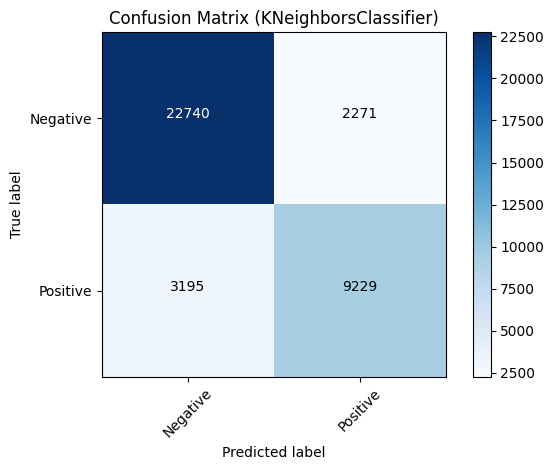

Classification Report (KNeighborsClassifier):
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     25011
           1       0.80      0.74      0.77     12424

    accuracy                           0.85     37435
   macro avg       0.84      0.83      0.83     37435
weighted avg       0.85      0.85      0.85     37435

Confusion matrix, without normalization
[[22478  2533]
 [ 9151  3273]]


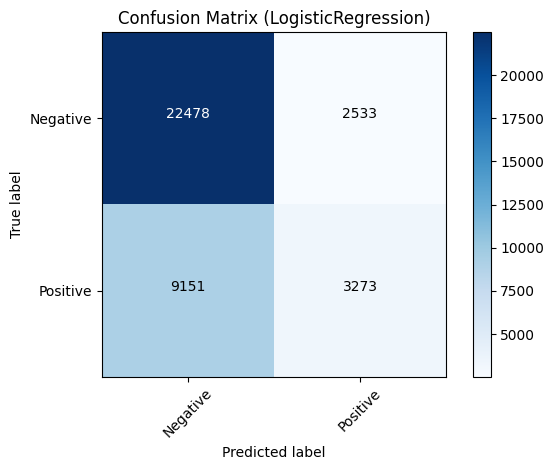

Classification Report (LogisticRegression):
              precision    recall  f1-score   support

           0       0.71      0.90      0.79     25011
           1       0.56      0.26      0.36     12424

    accuracy                           0.69     37435
   macro avg       0.64      0.58      0.58     37435
weighted avg       0.66      0.69      0.65     37435

Confusion matrix, without normalization
[[21565  3446]
 [ 3217  9207]]


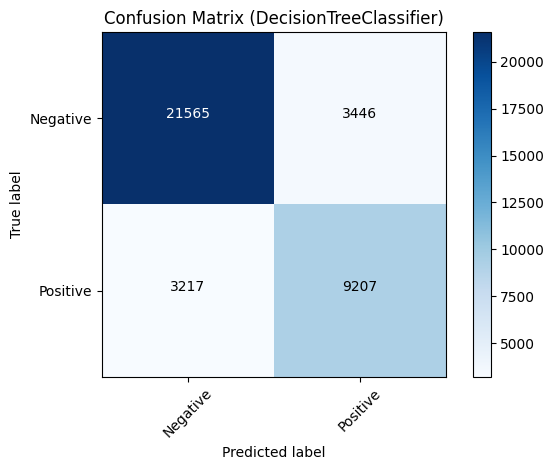

Classification Report (DecisionTreeClassifier):
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     25011
           1       0.73      0.74      0.73     12424

    accuracy                           0.82     37435
   macro avg       0.80      0.80      0.80     37435
weighted avg       0.82      0.82      0.82     37435

Confusion matrix, without normalization
[[23565  1446]
 [ 3100  9324]]


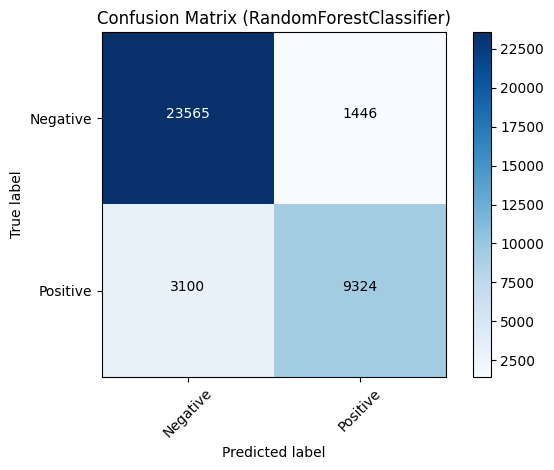

Classification Report (RandomForestClassifier):
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     25011
           1       0.87      0.75      0.80     12424

    accuracy                           0.88     37435
   macro avg       0.87      0.85      0.86     37435
weighted avg       0.88      0.88      0.88     37435

Confusion matrix, without normalization
[[23288  1723]
 [ 2877  9547]]


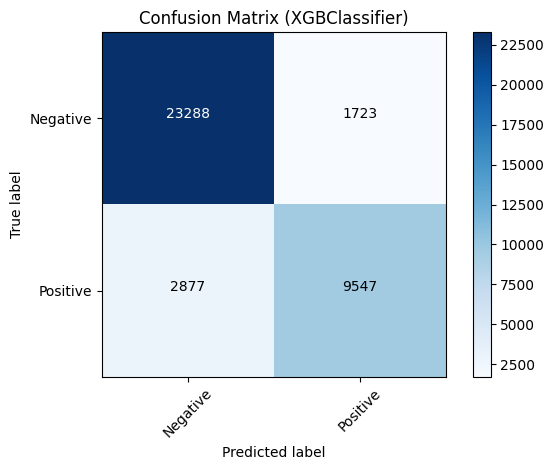

Classification Report (XGBClassifier):
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     25011
           1       0.85      0.77      0.81     12424

    accuracy                           0.88     37435
   macro avg       0.87      0.85      0.86     37435
weighted avg       0.88      0.88      0.88     37435



In [210]:
multi_model_eval(model_list, X, y, kf)

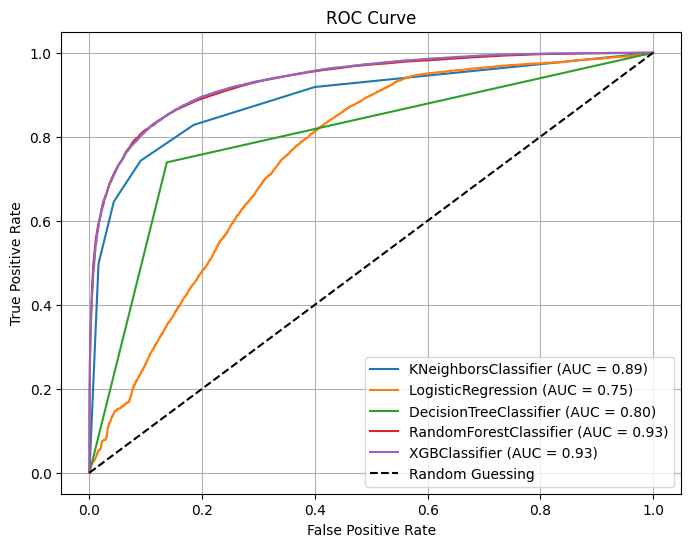

In [211]:
plt.figure(figsize=(8, 6))
for model in model_list:
    # Perform cross-validation
    y_scores = cross_val_predict(model, X, y, cv=kf, method="predict_proba")

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{type(model).__name__} (AUC = {roc_auc:.2f})')

# Plot random guessing line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
    
# Load KNeighborsClassifier model
with open('bots_detection_knn_model.pkl', 'rb') as knn_file:
    knn_model = pickle.load(knn_file)

# Load LogisticRegression model
with open('bots_detection_lr_model.pkl', 'rb') as lr_file:
    lr_model = pickle.load(lr_file)

In [ ]:
import pickle
from sklearn.metrics import accuracy_score

# Scale the test features
X_test_scaled = scaler.transform(X_test)

# Predict using KNeighborsClassifier model
knn_predictions = knn_model.predict(X_test_scaled)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("Accuracy of KNeighborsClassifier:", knn_accuracy)

# Predict using LogisticRegression model
lr_predictions = lr_model.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, lr_predictions)
print("Accuracy of LogisticRegression:", lr_accuracy)

In [ ]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold

# Initialize models
gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
xgb = XGBClassifier()

# List of models
model_list = [gnb, bnb, mnb, tree, forest, xgb]

# Initialize KFold cross-validator
kf = KFold(n_splits=3, shuffle=True, random_state=33)

# Content Moderation

## * url: URL of the content.
## * title: Title of the content.
## * asin: ASIN (Amazon Standard Identification Number).
## * price: Price of the product.
## * brand: Brand of the product.
## * product_details: Details of the product.
## * breadcrumbs: Breadcrumbs for navigation.
## * features: Features of the product.
## * location: Location of the content.
## * has_company_logo: Indicates whether the content has a company logo.
## * has_questions: Indicates whether the content has questions.
## * industry: Industry of the content.
## * fraudulent: Indicates whether the content is fraudulent.

In [212]:
import re
import string
import numpy as np
import pandas as pd
import random
import missingno
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

from wordcloud import WordCloud

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

In [213]:
data = pd.read_csv('/kaggle/input/content-moderation/content_moderation_dataset.csv', index_col=0)
data.head()

,url,title,asin,price,brand,product_details,breadcrumbs,features,location,has_company_logo,has_questions,industry,fraudulent
0,https://www.amazon.co.uk/dp/B08BLP231K,"Geox Jr Sandal Strada B Fisherman, Brown Red, ...",B08BLP231K,£50.00,Visit the Geox Store,Package Dimensions‏:‎31.2 x 21.4 x 11.4 cm; 82...,Shoes/Boys' Shoes/Sandals,"[{'Outer Material': 'Synthetic'}, {'Inner Mate...","US, NY, New York",1,0,NaN,0
1,https://www.amazon.co.uk/dp/B08N587YZ9,Fila Women's Oakmont Tr Sneaker,B08N587YZ9,£49.57 - £234.95,Fila,Product Dimensions‏:‎32.51 x 21.84 x 12.19 cm;...,Shoes/Women's Shoes/Fashion & Athletic Trainer...,"[{'Outer Material': 'fabric'}, {'Sole': 'Rubbe...","NZ, , Auckland",1,0,Marketing and Advertising,0
2,https://www.amazon.co.uk/dp/B0918K4H1W,Gabor Rollingsoft Trainers in Plus Sizes Beige...,B0918K4H1W,NaN,Gabor,Is Discontinued By Manufacturer‏:‎NoDate First...,Shoes/Women's Shoes/Fashion & Athletic Trainer...,"[{'Outer Material': 'Leather'}, {'Sole': 'Leat...","US, IA, Wever",1,0,NaN,0
3,https://www.amazon.co.uk/dp/B07KMB98CG,Merrell Women'S Bare Access Xtr Trail Running ...,B07KMB98CG,£67.00 - £182.44,Visit the Merrell Store,Package Dimensions‏:‎28.96 x 19.81 x 10.16 cm;...,Shoes/Women's Shoes/Fashion & Athletic Trainer...,"[{'Outer Material': 'Synthetic'}, {'Inner Mate...","US, DC, Washington",1,0,Computer Software,0
4,https://www.amazon.co.uk/dp/B08CN3S1ZK,Desigual Women's Shoes_Runner_cmofl Sneakers W...,B08CN3S1ZK,£38.96 - £81.10,Desigual,Package Dimensions‏:‎34.6 x 21.8 x 11.6 cm; 50...,Shoes/Women's Shoes/Fashion & Athletic Trainer...,"[{'Outer Material': 'Polyester'}, {'Inner Mate...","US, FL, Fort Worth",1,1,Hospital & Health Care,0


In [214]:
data.features[0]

"[{'Outer Material': 'Synthetic'}, {'Inner Material': 'Synthetic'}, {'Sole': 'Rubber'}, {'Closure': 'Strap'}, {'Heel Height': '2 centimetres'}, {'Heel Type': 'Flat'}, {'Shoe Width': 'Medium'}]"

## Data preprocessing

-  preprocess_features_string(features_str) >> convert the string into a valid JSON-like format.
- extract_shoe_materials(features_str) >>  extracts shoe materials from the preprocessed features string by the following :

*     Parses the preprocessed string into a Python list of dictionaries using ast.literal_eval.
*     Iterates over each feature dictionary in the list and extracts materials if they are present under keys like 'Outer Material', 'Inner Material', 'Sole', and 'Closure'.
*     Joins the extracted materials with commas.

In [215]:
import ast

# Function to preprocess the string representation of dictionaries
def preprocess_features_string(features_str):
    # Replace single quotes with double quotes
    features_str = features_str.replace("'", '"')
    return features_str

# Function to extract shoe materials from the preprocessed 'features' column
def extract_shoe_materials(features_str):
    # Preprocess the features string
    features_str = preprocess_features_string(features_str)
    
    try:
        # Parse the features string to a Python list of dictionaries
        features_list = ast.literal_eval(features_str)
    except (SyntaxError, ValueError):
        # Return an empty list if parsing fails
        return ''
    
    # List to store extracted materials
    materials = []
    
    # Iterate over each feature dictionary
    for feature in features_list:
        # Extract the value corresponding to 'Outer Material', 'Inner Material', 'Sole', and 'Closure' keys
        if 'Outer Material' in feature:
            materials.append(feature['Outer Material'])
        if 'Inner Material' in feature:
            materials.append(feature['Inner Material'])
        if 'Sole' in feature:
            materials.append(feature['Sole'])
        if 'Closure' in feature:
            materials.append(feature['Closure'])
    
    # Join the extracted materials with commas
    return ','.join(materials)

# Apply the function to clean the 'features' column
data['cleaned_features'] = data['features'].apply(extract_shoe_materials)


In [216]:
print(data.columns)
data.describe()

Index(['url', 'title', 'asin', 'price', 'brand', 'product_details',
       'breadcrumbs', 'features', 'location', 'has_company_logo',
       'has_questions', 'industry', 'fraudulent', 'cleaned_features'],
      dtype='object')


,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000
mean,0.795302,0.491723,0.048434
std,0.403492,0.499945,0.214688
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


In [217]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17880 entries, 0 to 17879
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   url               17880 non-null  object
 1   title             17880 non-null  object
 2   asin              17880 non-null  object
 3   price             17443 non-null  object
 4   brand             17878 non-null  object
 5   product_details   17226 non-null  object
 6   breadcrumbs       17296 non-null  object
 7   features          17880 non-null  object
 8   location          17534 non-null  object
 9   has_company_logo  17880 non-null  int64 
 10  has_questions     17880 non-null  int64 
 11  industry          12977 non-null  object
 12  fraudulent        17880 non-null  int64 
 13  cleaned_features  17880 non-null  object
dtypes: int64(3), object(11)
memory usage: 2.6+ MB


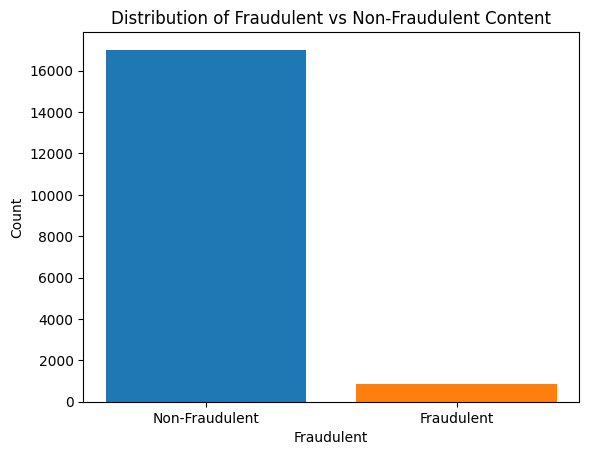

In [218]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'data' contains your DataFrame

# Count occurrences of each category in the 'fraudulent' column
fraudulent_counts = data['fraudulent'].value_counts()

# Plot the counts with default colors
plt.bar(fraudulent_counts.index, fraudulent_counts.values, color=['C0', 'C1'])

# Add labels and title
plt.xlabel('Fraudulent')
plt.ylabel('Count')
plt.title('Distribution of Fraudulent vs Non-Fraudulent Content')

# Add x-axis labels
plt.xticks(fraudulent_counts.index, ['Non-Fraudulent', 'Fraudulent'])

# Show plot
plt.show()


In [219]:
# Fill missing values with empty strings
data.fillna('', inplace=True)

In [220]:
data['text'] = data['title'] + ' ' + data['location'] + ' ' + data['brand'] +   ' ' + data['breadcrumbs'] +   ' '+ data['cleaned_features'] +' '+ data['industry']


In [221]:

columns_to_drop = ['title', 'location', 'brand', 'breadcrumbs', 'cleaned_features',
                   'features', 'industry', 'asin', 'has_company_logo', 'has_questions']
data.drop(columns=columns_to_drop, inplace=True)

In [222]:
data.head()

,url,price,product_details,fraudulent,text
0,https://www.amazon.co.uk/dp/B08BLP231K,£50.00,Package Dimensions‏:‎31.2 x 21.4 x 11.4 cm; 82...,0,"Geox Jr Sandal Strada B Fisherman, Brown Red, ..."
1,https://www.amazon.co.uk/dp/B08N587YZ9,£49.57 - £234.95,Product Dimensions‏:‎32.51 x 21.84 x 12.19 cm;...,0,"Fila Women's Oakmont Tr Sneaker NZ, , Auckland..."
2,https://www.amazon.co.uk/dp/B0918K4H1W,,Is Discontinued By Manufacturer‏:‎NoDate First...,0,Gabor Rollingsoft Trainers in Plus Sizes Beige...
3,https://www.amazon.co.uk/dp/B07KMB98CG,£67.00 - £182.44,Package Dimensions‏:‎28.96 x 19.81 x 10.16 cm;...,0,Merrell Women'S Bare Access Xtr Trail Running ...
4,https://www.amazon.co.uk/dp/B08CN3S1ZK,£38.96 - £81.10,Package Dimensions‏:‎34.6 x 21.8 x 11.6 cm; 50...,0,Desigual Women's Shoes_Runner_cmofl Sneakers W...


## Text preprocessing

## Generate word clouds
- Separating Text Data: (fraud_text) and non-fraudulent (actual_text) 
- Defining Stopwords: Stopwords are commonly used words (e.g., "the", "is", "and") that are often filtered out from text data because they typically do not carry significant meaning
- The WordCloud object is configured with parameters such as min_font_size, max_words, width, height, and stopwords
- generate method is used to create the word cloud by passing the text data as a string
**These word clouds provide visual representations of the most frequent words in the text data associated with fraudulent and non-fraudulent entries,**

In [224]:
fraud_text = data[data.fraudulent==1].text
actual_text = data[data.fraudulent==0].text

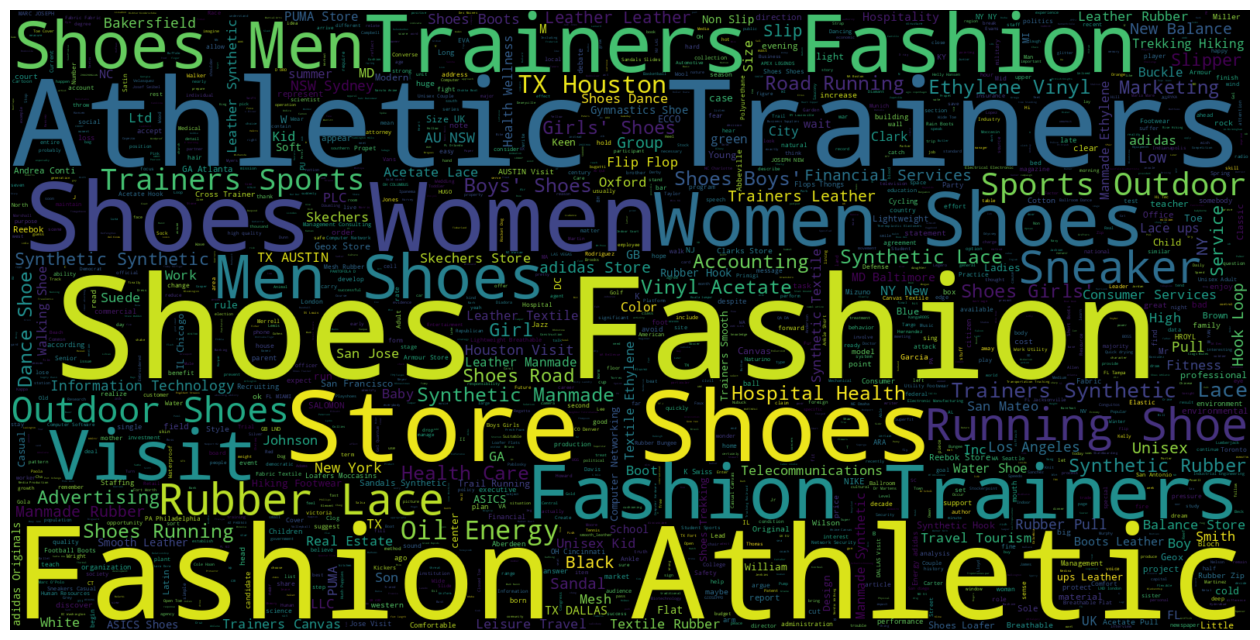

In [225]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize=(16, 14))
wc = WordCloud(min_font_size=3, max_words=3000, width=1600, height=800, stopwords=STOPWORDS).generate(str(" ".join(fraud_text)))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

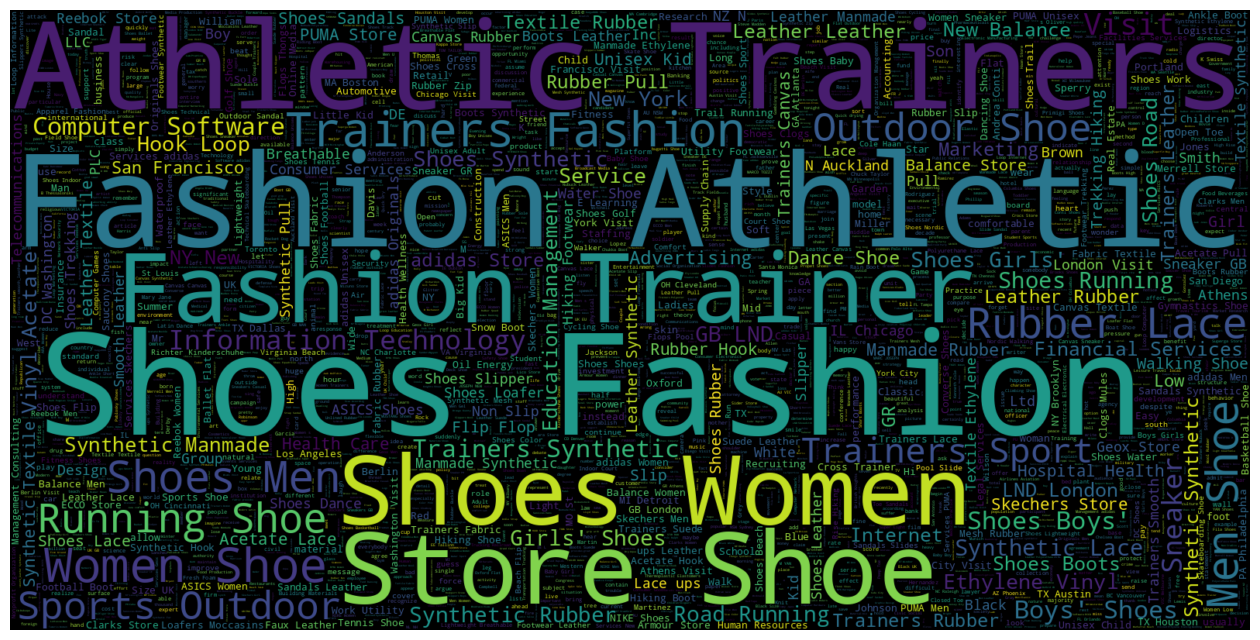

In [226]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize=(16, 14))
wc = WordCloud(min_font_size=3, max_words=3000, width=1600, height=800, stopwords=STOPWORDS).generate(str(" ".join(actual_text)))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

* Loading spaCy Model: The code loads the spaCy English model (en_core_web_sm) using spacy.load() function. This model includes the tokenizer, tagger, parser, named entity recognizer (NER), and word vectors.

* Creating Punctuation and Stopwords Lists: It defines lists of punctuation marks (punctuations) and stopwords (stop_words) using spaCy's built-in English stopwords.

Tokenizer Function: The spacy_tokenizer function is defined to preprocess text. Here's what it does:

* It takes a sentence as input.
* It parses the sentence using spaCy's nlp object, which tokenizes the text and performs other linguistic analyses.
* It lemmatizes each token (i.e., reduces it to its base or dictionary form) and converts it to lowercase. If a token is a pronoun ("-PRON-"), it uses the lowercase version of the token.
* It removes stopwords and punctuation tokens from the list of tokens.
* It returns the preprocessed list of tokens.

In [227]:
import spacy
from spacy.lang.en import English
import string

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")
parser = English()

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Custom analyzer function to preprocess text
def spacy_tokenizer(sentence):
    # Parse the sentence using SpaCy
    doc = nlp(sentence)
    
    # Lemmatize each token and convert to lowercase
    mytokens = [token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_ for token in doc]
    
    # Remove stop words and punctuations
    mytokens = [token for token in mytokens if token not in stop_words and token not in punctuations]
    
    # Return preprocessed list of tokens
    return mytokens


In [230]:
# Example text
example_text = """
Natural language processing (NLP) is a field of artificial intelligence that focuses on the interaction 
between computers and humans through natural language. The ultimate objective of NLP is to enable computers 
to understand, interpret, and generate human language in a way that is both meaningful and useful. 
SpaCy is an open-source library designed to help developers build applications that process and understand 
large volumes of text data. It provides a simple and efficient API for tokenization, part-of-speech tagging, 
named entity recognition, and more. In this example, we'll use the spacy_tokenizer function to tokenize this 
example text and demonstrate its capabilities.
"""

# Tokenize the example text using the spacy_tokenizer function
tokens = spacy_tokenizer(example_text)

# Print the tokens
print(tokens)

['natural', 'language', 'processing', 'nlp', 'field', 'artificial', 'intelligence', 'focus', 'interaction', 'computer', 'human', 'natural', 'language', 'ultimate', 'objective', 'nlp', 'enable', 'computer', 'understand', 'interpret', 'generate', 'human', 'language', 'way', 'meaningful', 'useful', 'spacy', 'open', 'source', 'library', 'design', 'help', 'developer', 'build', 'application', 'process', 'understand', 'large', 'volume', 'text', 'datum', 'provide', 'simple', 'efficient', 'api', 'tokenization', 'speech', 'tagging', 'entity', 'recognition', 'example', 'use', 'spacy_tokenizer', 'function', 'tokenize', 'example', 'text', 'demonstrate', 'capability']


* Custom Transformer Class: The predictors class is defined, which inherits from TransformerMixin. This class is used to create a transformer object that can be included in scikit-learn pipelines.

* transform Method: The transform method preprocesses the input data X. It calls the clean_text function for each text sample in X to clean the text data.

* fit Method: The fit method is implemented but does not perform any action since the transformer does not require training.

* get_params Method: The get_params method returns an empty dictionary since the transformer does not have any hyperparameters.

* clean_text Function:  It removes leading and trailing spaces and converts the text to lowercase.

In [231]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

**N-gram Range (ngram_range=(1,1)): This parameter determines the range of n-grams (sequences of consecutive words) to include in the bag-of-words representation. Here, (1,1) specifies that only unigrams (single words) are considered.**

**Vocabulary: The vocabulary of the bag-of-words matrix is constructed based on the unique tokens (words) extracted from the text data. The tokenizer function (spacy_tokenizer) is applied to each text document, and the unique tokens across all documents form the vocabulary.**

**Token Frequency: For each document in the text data, the tokenizer function tokenizes the text into individual words according to the specified rules. The CountVectorizer then counts the frequency of each token in each document and constructs a matrix where each row represents a document and each column represents a unique token in the vocabulary. The value at each position (i, j) in the matrix represents the frequency of the j-th token in the i-th document.**

In [232]:
# Create CountVectorizer with custom analyzer
bow_vector = CountVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1,1))

In [246]:
# Example data
sentences = [
    "This is a test sentence powerful",
    "We are trying out the custom tokenizer with spacy.",
    "spacy is a powerful tool for natural language processing. spacy is very great",
]
# Transform the sentences using the bow_vector
bow_matrix = bow_vector.fit_transform(sentences)

# Display the resulting bag-of-words matrix
print("Bag-of-words matrix:")
print(bow_matrix.toarray())

Bag-of-words matrix:
[[0 0 0 0 1 0 1 0 1 0 0 0]
 [1 0 0 0 0 0 0 1 0 1 0 1]
 [0 1 1 1 1 1 0 2 0 0 1 0]]


In [247]:
# Convert the bag-of-words matrix to a DataFrame
import pandas as pd
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_vector.get_feature_names_out())

# Display the DataFrame
print("\nBag-of-words DataFrame:")
bow_df



Bag-of-words DataFrame:


,custom,great,language,natural,powerful,processing,sentence,spacy,test,tokenizer,tool,try
0,0,0,0,0,1,0,1,0,1,0,0,0
1,1,0,0,0,0,0,0,1,0,1,0,1
2,0,1,1,1,1,1,0,2,0,0,1,0


## Model Training

In [248]:
# splitting our data in train and test
X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, test_size=0.2)

In [256]:
from sklearn.metrics import classification_report

def train_model(X_train, y_train, X_test, y_test, classifier, name):
    # Create pipeline using Bag of Words
    pipe = Pipeline([
        ("cleaner", predictors()),
        ('vectorizer', bow_vector),
        ('classifier', classifier)
    ])

    # Fit the model
    pipe.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipe.predict(X_test)

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print accuracy
    print(f"Model Accuracy ({name}): {accuracy}")
    
    # Compute classification report
    report = classification_report(y_test, y_pred)
    print(report)
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix with model name as title
    plt.figure(figsize=(8, 6))
    plt.title(f'Confusion Matrix ({name})')
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

    # Return the trained model
    return pipe


Training RandomForestClassifier...
Model Accuracy (RandomForestClassifier): 0.9513422818791947
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3395
           1       0.77      0.06      0.10       181

    accuracy                           0.95      3576
   macro avg       0.86      0.53      0.54      3576
weighted avg       0.94      0.95      0.93      3576



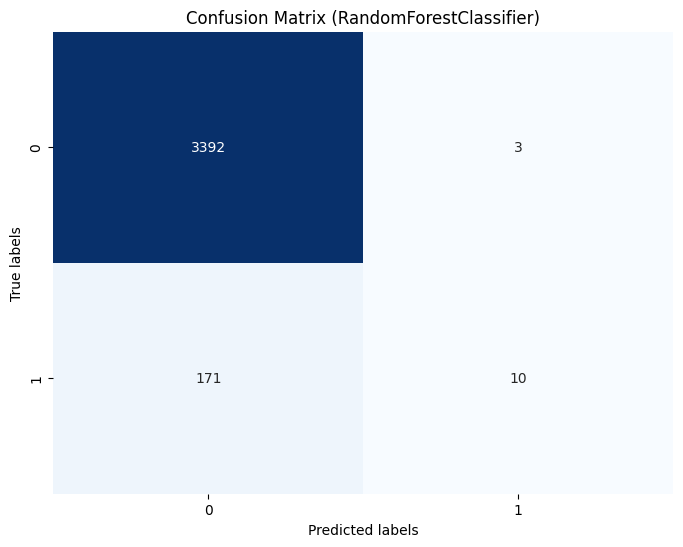

Model RandomForestClassifier saved as RandomForestClassifier_content_moderation.pkl

Training LogisticRegression...
Model Accuracy (LogisticRegression): 0.9471476510067114
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3395
           1       0.42      0.12      0.19       181

    accuracy                           0.95      3576
   macro avg       0.69      0.56      0.58      3576
weighted avg       0.93      0.95      0.93      3576



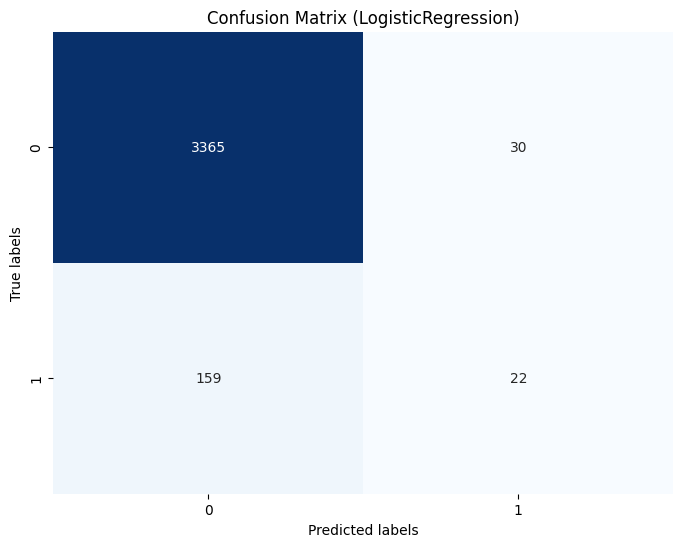

Model LogisticRegression saved as LogisticRegression_content_moderation.pkl

Training SVC...
Model Accuracy (SVC): 0.9493847874720358
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3395
           1       0.00      0.00      0.00       181

    accuracy                           0.95      3576
   macro avg       0.47      0.50      0.49      3576
weighted avg       0.90      0.95      0.92      3576



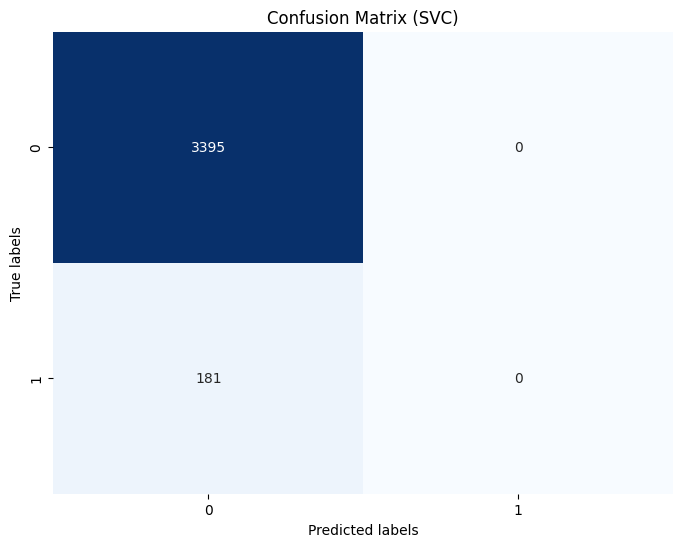

Model SVC saved as SVC_content_moderation.pkl

Training XGBClassifier...
Model Accuracy (XGBClassifier): 0.9541387024608501
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3395
           1       0.68      0.18      0.28       181

    accuracy                           0.95      3576
   macro avg       0.82      0.59      0.63      3576
weighted avg       0.94      0.95      0.94      3576



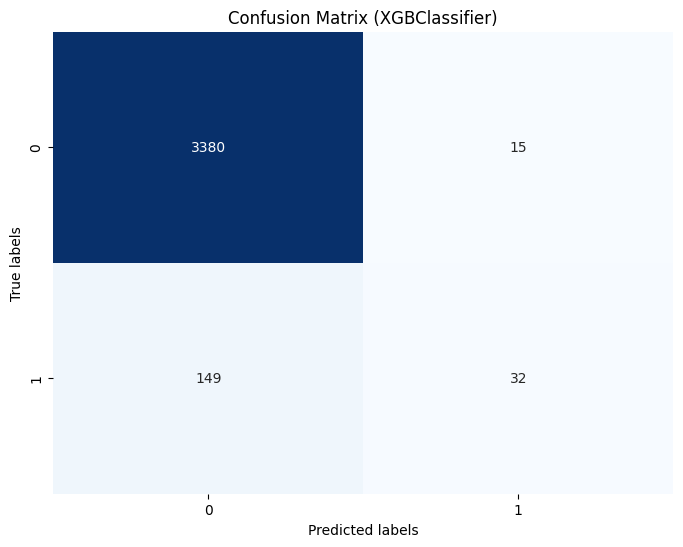

Model XGBClassifier saved as XGBClassifier_content_moderation.pkl



In [257]:
import pickle
# Define classifiers
classifiers = {
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "SVC": SVC(probability=True),
    "XGBClassifier": XGBClassifier()
}

# Train and save each model
for name, clf in classifiers.items():
    print(f"Training {name}...")
    trained_model = train_model(X_train, y_train, X_test, y_test, clf,name)
    # Save the trained model
    filename = f"{name}_content_moderation.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(trained_model, file)
    print(f"Model {name} saved as {filename}\n")

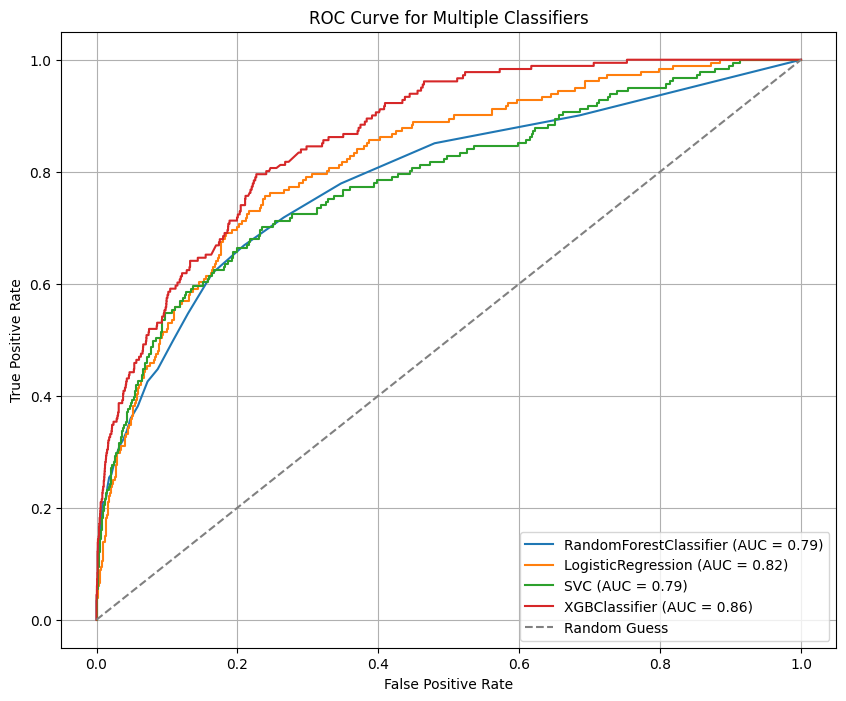

In [255]:
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define a dictionary to store FPR and TPR for each model
roc_data = {}

# Load trained models from pickle files
for name, _ in classifiers.items():
    filename = f"{name}_content_moderation.pkl"
    with open(filename, 'rb') as file:
        trained_model = pickle.load(file)
    # Predict probabilities for positive class
    y_prob = trained_model.predict_proba(X_test)[:, 1]
    # Calculate false positive rate, true positive rate, and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    # Store data in dictionary
    roc_data[name] = (fpr, tpr, roc_auc)

# Plot ROC curve for each model
plt.figure(figsize=(10, 8))
for name, data in roc_data.items():
    fpr, tpr, roc_auc = data
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiple Classifiers')
plt.legend()
plt.grid(True)
plt.show()
